In [1]:
#plot sample QC stratified by superpopulation
#variants filtered on DP (>20), GQ (>20) and VAF (>0.25) prior to sample QC to remove false positive variants
import hail as hl
import pyspark
from hail.plot import show
from bokeh.plotting import output_file, save
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels import robust
import numpy as np

hl.plot.output_notebook()

sc = pyspark.SparkContext()
tmp_dir = "hdfs://spark-master:9820/"
lustre_dir = "file:///lustre/scratch125/teams/hgi/ad7/otar2064/qc/"
plot_dir = "/lustre/scratch125/teams/hgi/ad7/otar2064/qc/plots/"

hl.init(sc=sc, tmp_dir=tmp_dir, default_reference="GRCh38")

Loading BokehJS ...

2024-01-30 15:02:55.617 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.3
SparkUI available at http://spark-master:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.105-acd89e80c345
LOGGING: writing to /home/ubuntu/data/sample_qc/hail-20240130-1502-0.2.105-acd89e80c345.log


In [4]:
ht_sample_qc_file = lustre_dir + "matrixtables/mt_pops_QC_filters.ht"
ht = hl.read_table(ht_sample_qc_file)
ht.show()

+-------------------+--------------+-------------------------+
| s                 | assigned_pop | sample_qc.dp_stats.mean |
+-------------------+--------------+-------------------------+
| str               | str          |                 float64 |
+-------------------+--------------+-------------------------+
| "EGAN00004260894" | "SAS"        |                2.68e+01 |
| "EGAN00004260895" | "SAS"        |                2.89e+01 |
| "EGAN00004260896" | "AFR"        |                2.66e+01 |
| "EGAN00004260897" | "EUR"        |                2.58e+01 |
| "EGAN00004260898" | "AFR"        |                2.68e+01 |
| "EGAN00004260899" | "SAS"        |                2.76e+01 |
| "EGAN00004260900" | "SAS"        |                2.71e+01 |
| "EGAN00004260901" | "EUR"        |                3.18e+01 |
| "EGAN00004260902" | "SAS"        |                2.71e+01 |
| "EGAN00004260903" | "SAS"        |                2.60e+01 |
+-------------------+--------------+-------------------------+

+--------------------------+------------------------+------------------------+
| sample_qc.dp_stats.stdev | sample_qc.dp_stats.min | sample_qc.dp_stats.max |
+--------------------------+------------------------+------------------------+
|                  float64 |                float64 |                float64 |
+--------------------------+------------------------+------------------------+
|                 5.82e+01 |               2.10e+01 |               7.54e+03 |
|                 7.37e+01 |               2.10e+01 |               7.44e+03 |
|                 5.45e+01 |               2.10e+01 |               7.52e+03 |
|                 4.95e+01 |               2.10e+01 |               7.48e+03 |
|                 5.55e+01 |               2.10e+01 |               7.48e+03 |
|                 6.64e+01 |               2.10e+01 |               7.47e+03 |
|                 5.75e+01 |               2.10e+01 |               7.46e+03 |
|                 8.93e+01 |               2.10e+01 |               7.46e+03 |
|                 6.45e+01 |               2.10e+01 |               7.51e+03 |
|                 5.11e+01 |               2.10e+01 |               7.48e+03 |
+--------------------------+------------------------+------------------------+

+-------------------------+--------------------------+------------------------+
| sample_qc.gq_stats.mean | sample_qc.gq_stats.stdev | sample_qc.gq_stats.min |
+-------------------------+--------------------------+------------------------+
|                 float64 |                  float64 |                float64 |
+-------------------------+--------------------------+------------------------+
|                6.80e+01 |                 1.65e+01 |               2.10e+01 |
|                6.87e+01 |                 1.75e+01 |               2.10e+01 |
|                6.84e+01 |                 1.75e+01 |               2.10e+01 |
|                6.78e+01 |                 1.59e+01 |               2.10e+01 |
|                6.90e+01 |                 1.68e+01 |               2.10e+01 |
|                6.80e+01 |                 1.68e+01 |               2.10e+01 |
|                6.76e+01 |                 1.69e+01 |               2.10e+01 |
|                6.98e+01 |                 1.85e+01 |               2.10e+01 |
|                6.81e+01 |                 1.63e+01 |               2.10e+01 |
|                6.83e+01 |                 1.58e+01 |               2.10e+01 |
+-------------------------+--------------------------+------------------------+

+------------------------+---------------------+--------------------+
| sample_qc.gq_stats.max | sample_qc.call_rate | sample_qc.n_called |
+------------------------+---------------------+--------------------+
|                float64 |             float64 |              int64 |
+------------------------+---------------------+--------------------+
|               9.90e+01 |            1.12e-01 |            3112318 |
|               9.90e+01 

In [3]:
 #look at pass/fail per pop for each metric
annot_tsv = lustre_dir + "annotations/sample_qc_by_pop.tsv.bgz"
df = pd.read_csv(annot_tsv, compression="gzip",sep="\t")
df.groupby("assigned_pop")["fail_heterozygosity_rate"].value_counts()

assigned_pop  fail_heterozygosity_rate
AFR           False                       22
AMR           True                         1
EAS           True                         1
EUR           False                       18
              True                         2
SAS           False                       41
Name: fail_heterozygosity_rate, dtype: int64

In [4]:
df.groupby("assigned_pop")["fail_n_snp"].value_counts()

assigned_pop  fail_n_snp
AFR           False         22
AMR           True           1
EAS           True           1
EUR           False         16
              True           4
SAS           False         41
Name: fail_n_snp, dtype: int64

In [5]:
df.groupby("assigned_pop")["fail_r_het_hom_var"].value_counts()

assigned_pop  fail_r_het_hom_var
AFR           False                 22
AMR           True                   1
EAS           True                   1
EUR           False                 18
              True                   2
SAS           False                 41
Name: fail_r_het_hom_var, dtype: int64

In [19]:
df.groupby("assigned_pop")["fail_r_ti_tv"].value_counts()

assigned_pop  fail_r_ti_tv
AFR           False           22
AMR           True             1
EAS           True             1
EUR           False           19
              True             1
SAS           False           40
              True             1
Name: fail_r_ti_tv, dtype: int64

In [6]:
df.groupby("assigned_pop")["qc_metrics_filters"].value_counts()

assigned_pop  qc_metrics_filters                                                                                                                         
AFR           []                                                                                                                                             22
AMR           ["n_transition","heterozygosity_rate","r_ti_tv","n_transversion","n_deletion","r_het_hom_var","n_snp","r_insertion_deletion","n_insertion"]     1
EAS           ["n_transition","heterozygosity_rate","r_ti_tv","n_transversion","n_deletion","r_het_hom_var","n_snp","r_insertion_deletion","n_insertion"]     1
EUR           []                                                                                                                                             14
              ["n_transition","n_transversion","n_deletion","n_snp","r_insertion_deletion","n_insertion"]                                                     4
              ["heterozygosity_rate","r_het_ho

In [7]:
df.count()

s                            85
assigned_pop                 85
sample_qc                    85
fail_heterozygosity_rate     85
fail_n_snp                   85
fail_r_ti_tv                 85
fail_n_transition            85
fail_n_transversion          85
fail_r_insertion_deletion    85
fail_n_insertion             85
fail_n_deletion              85
fail_r_het_hom_var           85
qc_metrics_filters           85
dtype: int64

In [12]:
#violin plots with +/-4MAD

#create subset for each assigned pop, and convert each to a pandas dataframe
AFRht = ht.filter(ht.assigned_pop == 'AFR')
AMRht = ht.filter(ht.assigned_pop == 'AMR')
EURht = ht.filter(ht.assigned_pop == 'EUR')
EASht = ht.filter(ht.assigned_pop == 'EAS')
SASht = ht.filter(ht.assigned_pop == 'SAS')
#othht = ht.filter(ht.assigned_pop == 'oth')

AFR_df = AFRht.to_pandas(flatten=True).dropna()
AMR_df = AMRht.to_pandas(flatten=True).dropna()
EUR_df = EURht.to_pandas(flatten=True).dropna()
EAS_df = EASht.to_pandas(flatten=True).dropna()
SAS_df = SASht.to_pandas(flatten=True).dropna()
#oth_df = othht.to_pandas(flatten=True).dropna()
all_df = ht.to_pandas(flatten=True).dropna()



In [22]:
#plotting functions
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Superpopulation')
    
def violin_plot(metric, label):
    
    m1 = AFR_df[metric].median()
    m2 = AMR_df[metric].median()
    m3 = EAS_df[metric].median()
    m4 = EUR_df[metric].median()
    m5 = SAS_df[metric].median()
    #m6 = oth_df[metric].median()
    mad1 = robust.mad(AFR_df[metric])
    mad2 = robust.mad(AMR_df[metric])
    mad3 = robust.mad(EAS_df[metric])
    mad4 = robust.mad(EUR_df[metric])
    mad5 = robust.mad(SAS_df[metric])
    #mad6 = robust.mad(oth_df[metric])
    meds = np.array([m1, m2, m3, m4, m5])
    q1 = np.array([m1-(4*mad1), m2-(4*mad2), m3-(4*mad3), m4-(4*mad4), m5-(4*mad5)])
    q2 = np.array([m1+(4*mad1), m2+(4*mad2), m3+(4*mad3), m4+(4*mad4), m5+(4*mad5)])

    fig, ax = plt.subplots()
    plottitle = label + " per superpopulation: \nMedians and +/-4xMAD per superpopulation shown"
    ax.set_title(plottitle)
    ax.set_ylabel(label)

    violin_parts = ax.violinplot([AFR_df[metric].astype(float), AMR_df[metric].astype(float), EAS_df[metric].astype(float), EUR_df[metric].astype(float), SAS_df[metric].astype(float)], showmeans=False, showmedians=False, showextrema=False)

    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('black')
    
    inds = np.arange(1, len(meds) + 1)
    ax.scatter(inds, meds, marker='o', color='black', s=30, zorder=3)
    ax.vlines(inds, q1, q2, color='k', linestyle='-', lw=2)
    labels = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
    set_axis_style(ax, labels)

    #plt.show()
    metric = metric.replace('.', '_')
    plotfile = plot_dir + '/sample_qc/' + metric + '_violin_with_4MAD.png'
    plt.savefig(plotfile, dpi=100)

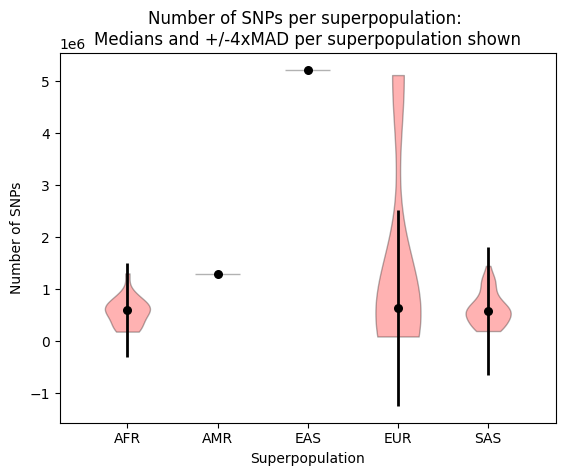

In [23]:
violin_plot('sample_qc.n_snp', 'Number of SNPs')

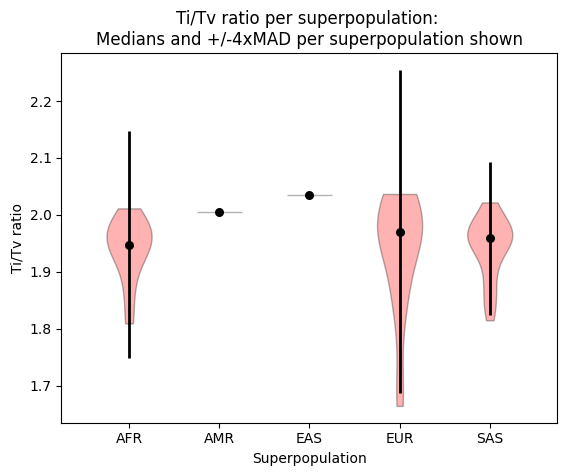

In [24]:
violin_plot('sample_qc.r_ti_tv', 'Ti/Tv ratio')

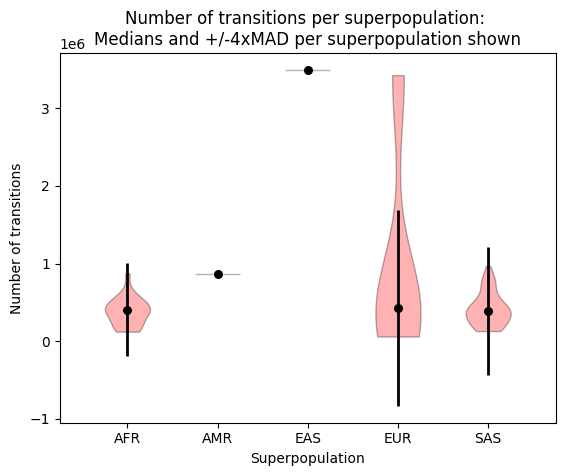

In [25]:
violin_plot('sample_qc.n_transition', 'Number of transitions')

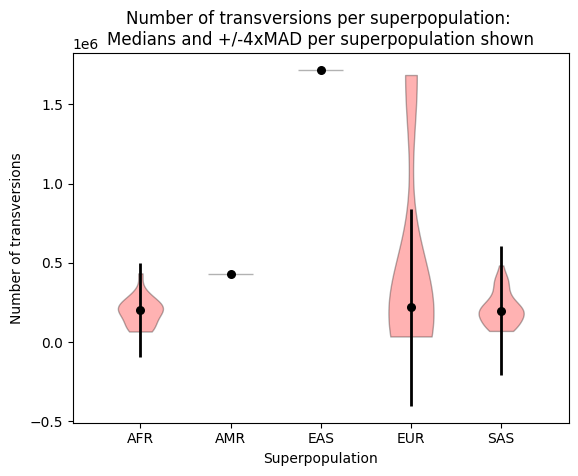

In [26]:
violin_plot('sample_qc.n_transversion', 'Number of transversions')

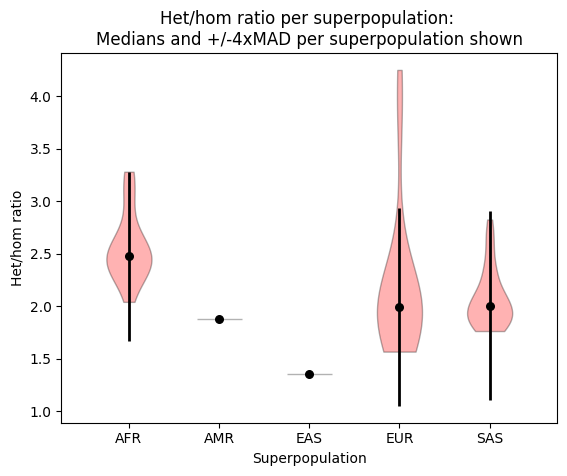

In [27]:
violin_plot('sample_qc.r_het_hom_var', 'Het/hom ratio')

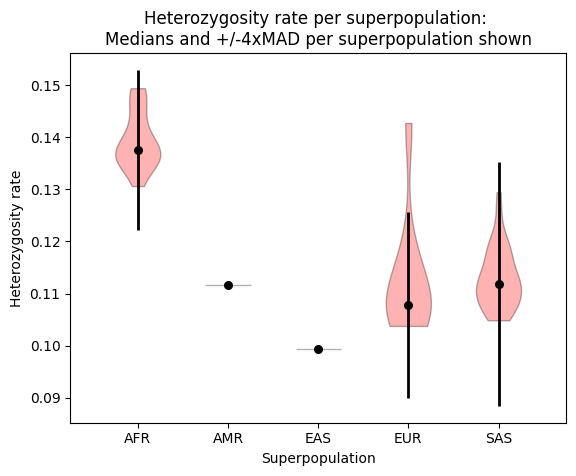

In [28]:
violin_plot('sample_qc.heterozygosity_rate', 'Heterozygosity rate')

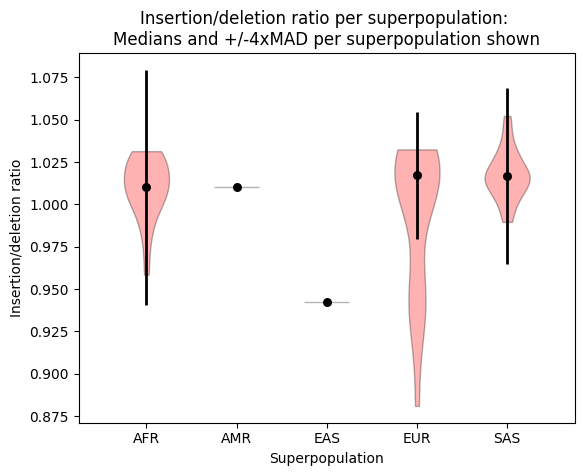

In [29]:
violin_plot('sample_qc.r_insertion_deletion', 'Insertion/deletion ratio')

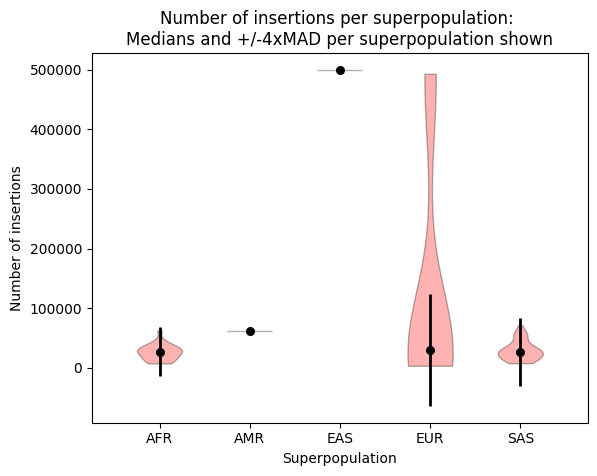

In [30]:
violin_plot('sample_qc.n_insertion', 'Number of insertions')

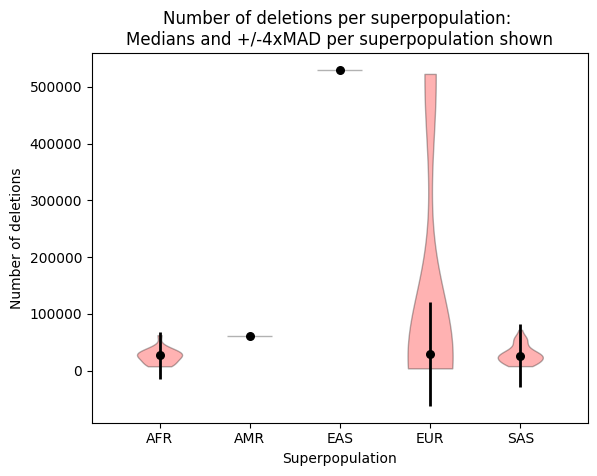

In [31]:
violin_plot('sample_qc.n_deletion', 'Number of deletions')